In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import h5py

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
# classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), 6.446446446446447e-01, 1), ((0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14), 0.6316316316316316, 0.6446446446446447), ((0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14), 0.5925925925925926, 0.6316316316316316), ((0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14), 0.4854854854854855, 0.5925925925925926), ((1, 2, 3, 4, 6, 7, 8, 11, 12, 14), 0.44844844844844844, 0.4854854854854855), ((0, 10), 0.44544544544544545, 0.4854854854854855), ((1, 2, 3, 4, 6, 7, 8, 12, 14), 0.43043043043043044, 0.44844844844844844), ((1, 2, 4, 6, 7, 12, 14), 0.40040040040040037, 0.43043043043043044), ((1, 2, 4, 6, 7, 12), 0.3733733733733734, 0.40040040040040037), ((3, 8), 0.3683683683683684, 0.43043043043043044), ((4, 7, 12), 0.3313313313313313, 0.3733733733733734), ((1, 2, 6), 0.2932932932932933, 0.3733733733733734), ((1, 2), 0.27427427427427425, 0.2932932932932933), ((4, 7), 0.12512512512512514, 0.3313313313313313), ((5,), 0, 0.6446446446446447), ((9,), 0, 0.6316316316316316), ((13,), 0, 0.5925925925925926), ((11,), 0, 0.44844844844844844), ((0,), 0, 0.44544544544544545), ((10,), 0, 0.44544544544544545), ((14,), 0, 0.40040040040040037), ((8,), 0, 0.3683683683683684), ((3,), 0, 0.3683683683683684), ((12,), 0, 0.3313313313313313), ((6,), 0, 0.2932932932932933), ((2,), 0, 0.27427427427427425), ((1,), 0, 0.27427427427427425), ((4,), 0, 0.12512512512512514), ((7,), 0, 0.12512512512512514)]
# branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), 0, 1)]

classes = [0, 1, 2, 3, 4, 5, 7, 10, 12]
branch_defs = [((0, 1, 2, 3, 4, 5, 7, 10, 12), 6.436436436436437e-01, 1), ((0, 1, 2, 3, 4, 7, 10, 12), 0.5405405405405406, 0.6436436436436437), ((1, 2, 3, 4, 7, 12), 0.5085085085085085, 0.5405405405405406), ((0, 10), 0.45045045045045046, 0.5405405405405406), ((1, 2, 4, 7, 12), 0.37237237237237236, 0.5085085085085085), ((4, 7, 12), 0.36436436436436437, 0.37237237237237236), ((1, 2), 0.22922922922922923, 0.37237237237237236), ((4, 7), 0.1841841841841842, 0.36436436436436437), ((5,), 0, 0.6436436436436437), ((3,), 0, 0.5085085085085085), ((0,), 0, 0.45045045045045046), ((10,), 0, 0.45045045045045046), ((12,), 0, 0.36436436436436437), ((1,), 0, 0.22922922922922923), ((2,), 0, 0.22922922922922923), ((7,), 0, 0.1841841841841842), ((4,), 0, 0.1841841841841842)]

# classes = [0]
# branch_defs = [((0,), 0, 1)]

# classes = [0, 1, 5]
# branch_defs = [((0, 1, 5), 6.786786786786787e-01, 1), ((0, 1), 0.5795795795795796, 0.6786786786786787), ((5,), 0, 0.6786786786786787), ((0,), 0, 0.5795795795795796), ((1,), 0, 0.5795795795795796)]

In [4]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"

dataset = scrna_dataset.SingleCellDataset(data_file)

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

In [25]:
# Import gene names and marker genes
with h5py.File(data_file, "r") as f:
    gene_names = f["gene_names"][:].astype(str)
    marker_genes = {}
    for class_i in classes:
        marker_genes[class_i] = f["marker_genes"][str(class_i)][:].astype(str)
    
genes_of_interest = np.array(["NFKB1", "NFKB2", "IRF1", "CXCR3", "CXCL10", "STAT1", "TLR4", "TGFB1", "IL1B", "IFNG", "TLR4", "TNFSF4", "IL1R2", "IL1B", "IL7R", "IL32"])

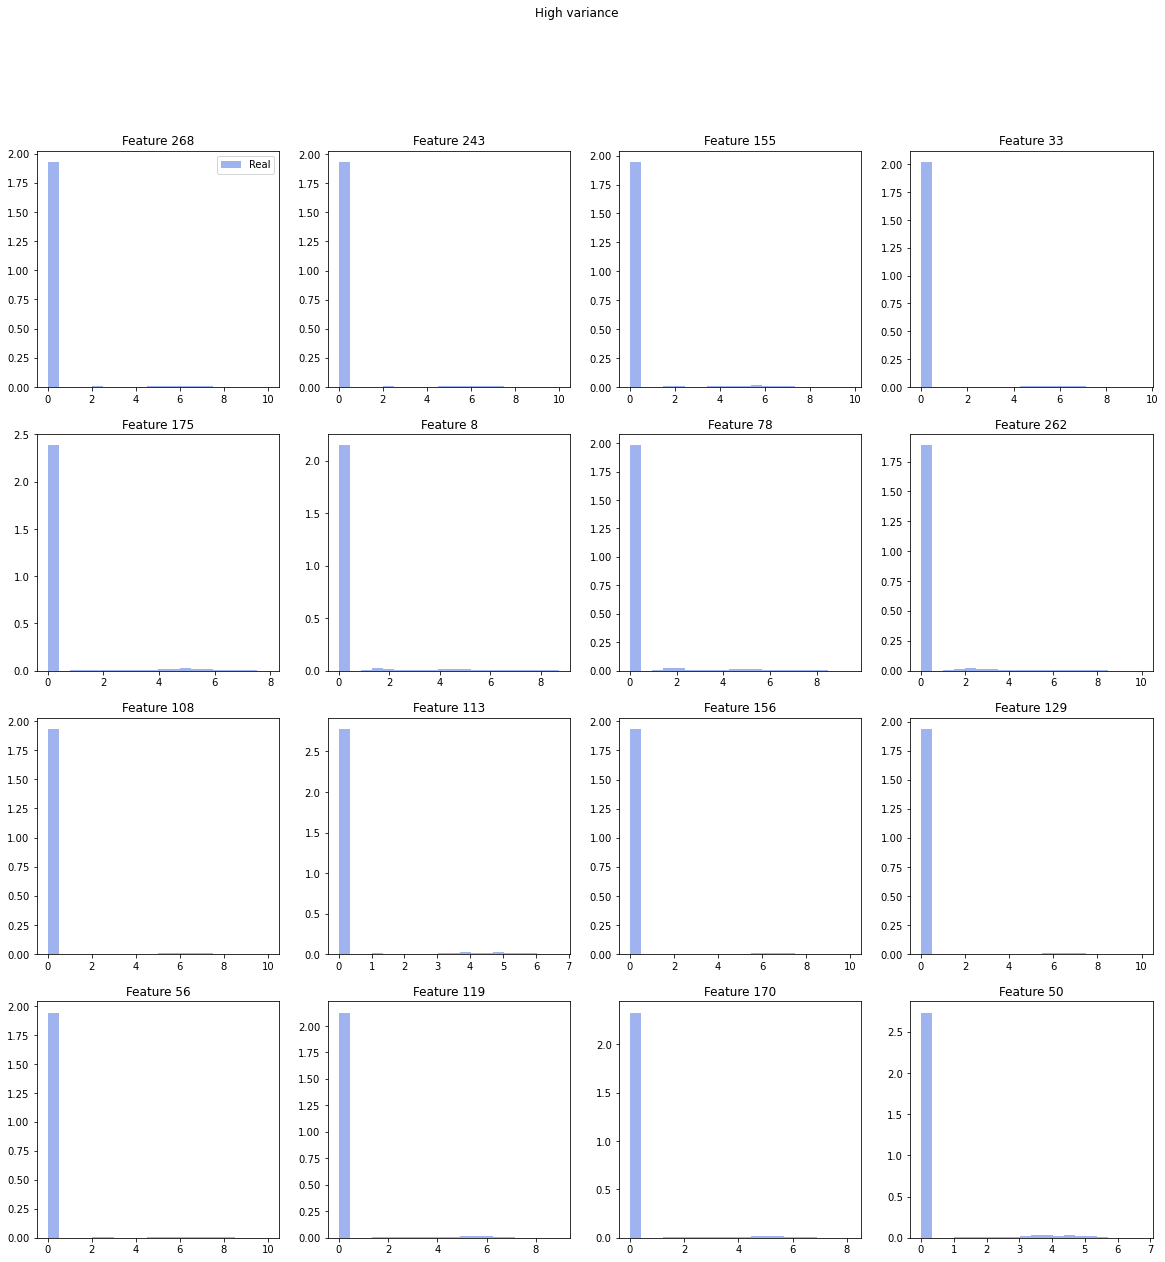

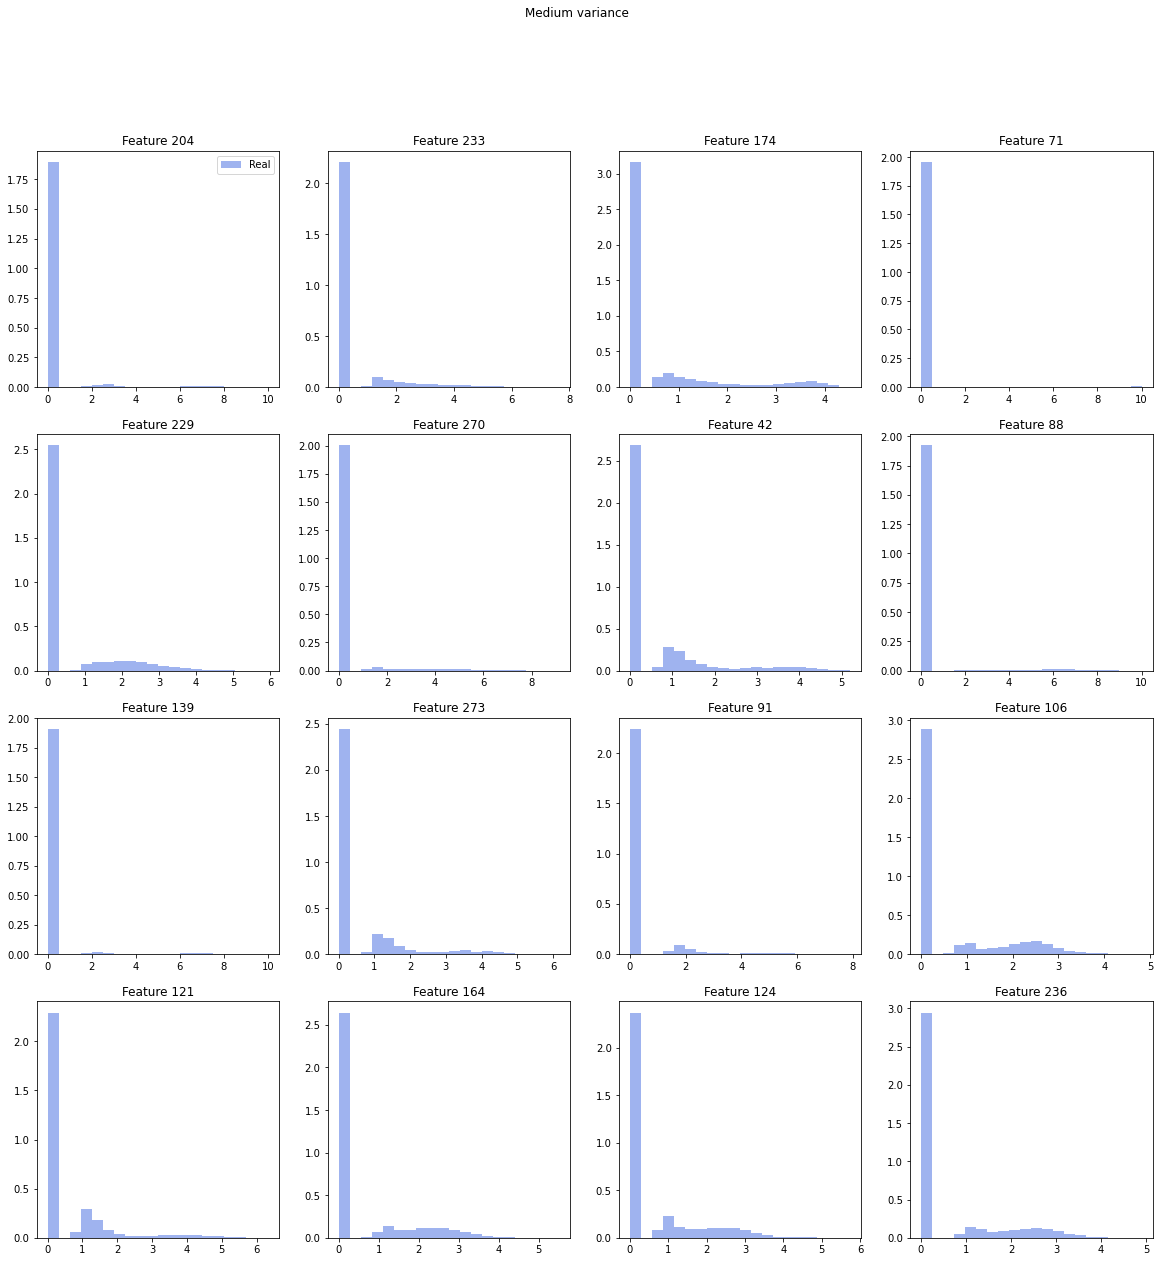

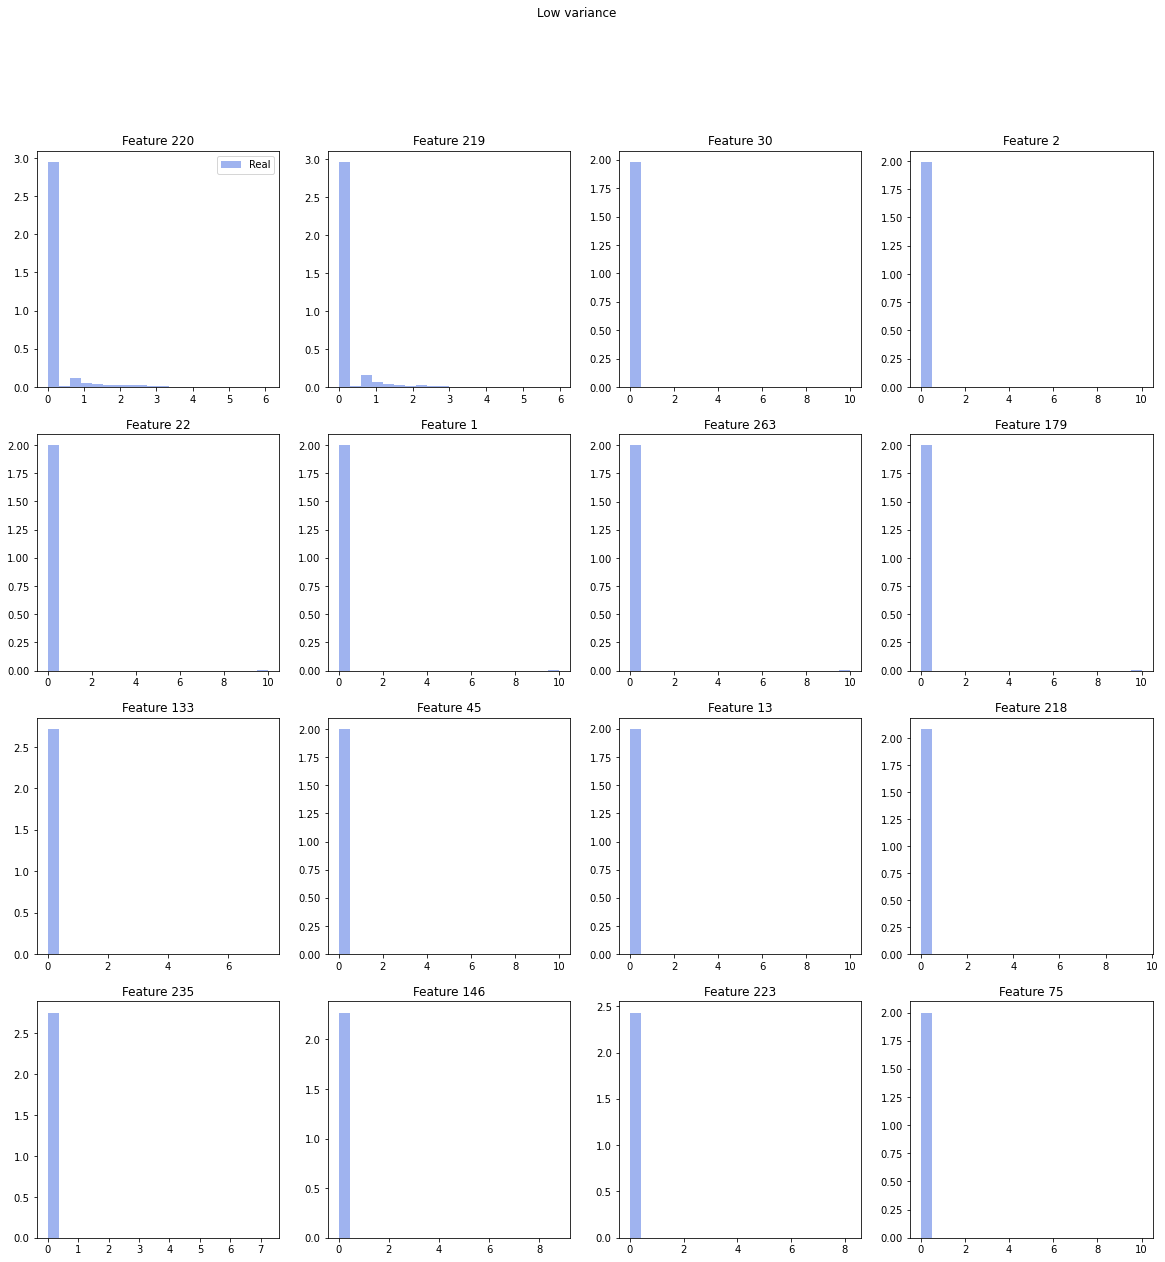

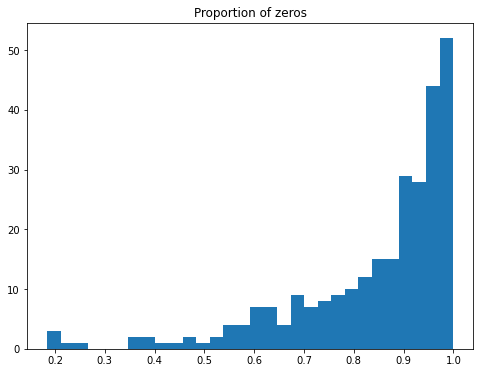

In [5]:
# Plot features
x = dataset.data
inds = np.flip(np.argsort(np.std(x, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = x[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.sum(x == 0, axis=0) / x.shape[0], bins=30)
ax.set_title("Proportion of zeros")
plt.show()

In [6]:
epsilon = 1e-6

feature_zero_props = np.maximum(1 - (np.sum(x == 0, axis=0) / x.shape[0]), epsilon)
feature_zero_weights = torch.tensor(feature_zero_props, device=DEVICE)

def weight_func(x0):
    """
    Given a tensor x0 of original features, computes a weighting for
    each feature of x0 in training.
    """
    weights = torch.tile(feature_zero_weights, x0.shape[:1] + ((1,) * len(x0.shape[1:])))
    weights[x0 != 0] = 1
    return weights

In [7]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [8]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)

t_limit = 1

model = scrna_ae.MultitaskResNet(
    len(branch_defs), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_covid_flu_continuous_allcells"
import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

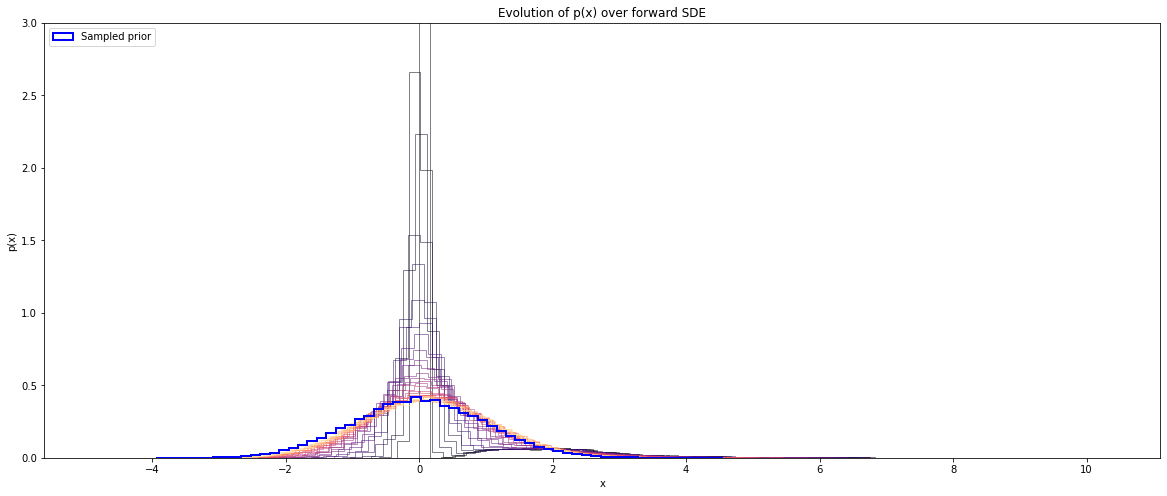

In [9]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [10]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 300,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm",
        "weight_func": weight_func
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
WARNING - root - Added new config entry: "weight_func"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "6"
Loss: 54.44: 100%|███████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 1 average Loss: 91.59


Loss: 48.69: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 2 average Loss: 53.08


Loss: 46.89: 100%|███████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 3 average Loss: 48.20


Loss: 41.72: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 4 average Loss: 44.94


Loss: 43.40: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 5 average Loss: 43.47


Loss: 42.43: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 6 average Loss: 42.32


Loss: 42.43: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 7 average Loss: 41.43


Loss: 42.88: 100%|███████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 8 average Loss: 41.04


Loss: 45.20: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 9 average Loss: 40.30


Loss: 35.59: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 10 average Loss: 39.96


Loss: 38.89: 100%|███████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 11 average Loss: 39.50


Loss: 41.18: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 12 average Loss: 38.95


Loss: 41.66: 100%|███████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 13 average Loss: 38.58


Loss: 38.15:  78%|████████████████████████████████████▌          | 195/251 [01:31<00:26,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 35.43: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.15it/s]


Epoch 41 average Loss: 34.89


Loss: 33.68: 100%|██████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 42 average Loss: 34.57


Loss: 41.11: 100%|██████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 43 average Loss: 34.54


Loss: 31.52: 100%|██████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 44 average Loss: 34.47


Loss: 35.44: 100%|██████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 45 average Loss: 34.25


Loss: 32.83: 100%|██████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 46 average Loss: 34.22


Loss: 33.10:  48%|█████████████████████▉                        | 120/251 [00:56<01:00,  2.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 34.03: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 74 average Loss: 32.85


Loss: 33.75: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 75 average Loss: 32.78


Loss: 33.77: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 76 average Loss: 32.69


Loss: 28.85: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 77 average Loss: 32.77


Loss: 31.63: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 78 average Loss: 32.63


Loss: 29.03:  99%|█████████████████████████████████████████████▋| 249/251 [01:56<00:00,  2.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 30.68: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 106 average Loss: 31.68


Loss: 32.81: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 107 average Loss: 31.70


Loss: 32.06: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 108 average Loss: 31.46


Loss: 33.34: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 109 average Loss: 31.45


Loss: 29.71: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 110 average Loss: 31.54


Loss: 33.80: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 111 average Loss: 31.58


Loss: 30.96:  77%|███████████████████████████████████▌          | 194/251 [01:30<00:26,  2.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 27.17: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 139 average Loss: 30.90


Loss: 29.75: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 140 average Loss: 30.76


Loss: 29.16: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 141 average Loss: 30.85


Loss: 30.43: 100%|██████████████████████████████████████████████| 251/251 [01:56<00:00,  2.15it/s]


Epoch 142 average Loss: 30.64


Loss: 30.98: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 143 average Loss: 30.72


Loss: 27.68: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 144 average Loss: 30.58


Loss: 29.82:  19%|████████▊                                      | 47/251 [00:21<01:34,  2.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 34.87: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 169 average Loss: 30.01


Loss: 30.75: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 170 average Loss: 29.86


Loss: 30.04: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 171 average Loss: 30.19


Loss: 30.37: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 172 average Loss: 30.08


Loss: 34.52: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 173 average Loss: 30.09


Loss: 34.89: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 174 average Loss: 30.00


Loss: 27.41:   2%|▊                                               | 4/251 [00:01<01:54,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 30.21: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 201 average Loss: 29.53


Loss: 27.99: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 202 average Loss: 29.40


Loss: 30.58: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 203 average Loss: 29.29


Loss: 29.65: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 204 average Loss: 29.38


Loss: 29.43: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 205 average Loss: 29.50


Loss: 31.22:  98%|█████████████████████████████████████████████▎| 247/251 [01:55<00:01,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 25.18: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 232 average Loss: 29.00


Loss: 28.97: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 233 average Loss: 29.07


Loss: 28.59: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 234 average Loss: 29.02


Loss: 30.13: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 235 average Loss: 29.04


Loss: 29.13: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 236 average Loss: 28.73


Loss: 27.63: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.14it/s]


Epoch 237 average Loss: 28.90


Loss: 30.85:  22%|██████████                                     | 54/251 [00:25<01:31,  2.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 32.16: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 264 average Loss: 28.74


Loss: 26.01: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 265 average Loss: 28.51


Loss: 30.41: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 266 average Loss: 28.54


Loss: 27.68: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 267 average Loss: 28.53


Loss: 31.78: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 268 average Loss: 28.38


Loss: 30.74: 100%|██████████████████████████████████████████████| 251/251 [01:57<00:00,  2.13it/s]


Epoch 269 average Loss: 28.43


Loss: 31.68:  16%|███████▋                                       | 41/251 [00:19<01:38,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 27.58: 100%|██████████████████████████████████████████████| 251/251 [01:58<00:00,  2.12it/s]


Epoch 293 average Loss: 28.33


Loss: 28.55: 100%|██████████████████████████████████████████████| 251/251 [01:58<00:00,  2.12it/s]


Epoch 294 average Loss: 28.23


Loss: 30.06: 100%|██████████████████████████████████████████████| 251/251 [01:58<00:00,  2.12it/s]


Epoch 295 average Loss: 28.30


Loss: 29.86: 100%|██████████████████████████████████████████████| 251/251 [01:58<00:00,  2.13it/s]


Epoch 296 average Loss: 28.27


Loss: 28.02:  93%|██████████████████████████████████████████▉   | 234/251 [01:51<00:07,  2.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss: 27.69: 100%|██████████████████████████████████████████████| 251/251 [01:59<00:00,  2.11it/s]


Epoch 300 average Loss: 28.22


INFO - train - Completed after 10:31:30


### Show generated distributions

In [11]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit, num_steps=1000, verbose=True
    ).cpu().numpy()
    samples[class_to_sample] = sample

100%|████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.12it/s]


Class 0


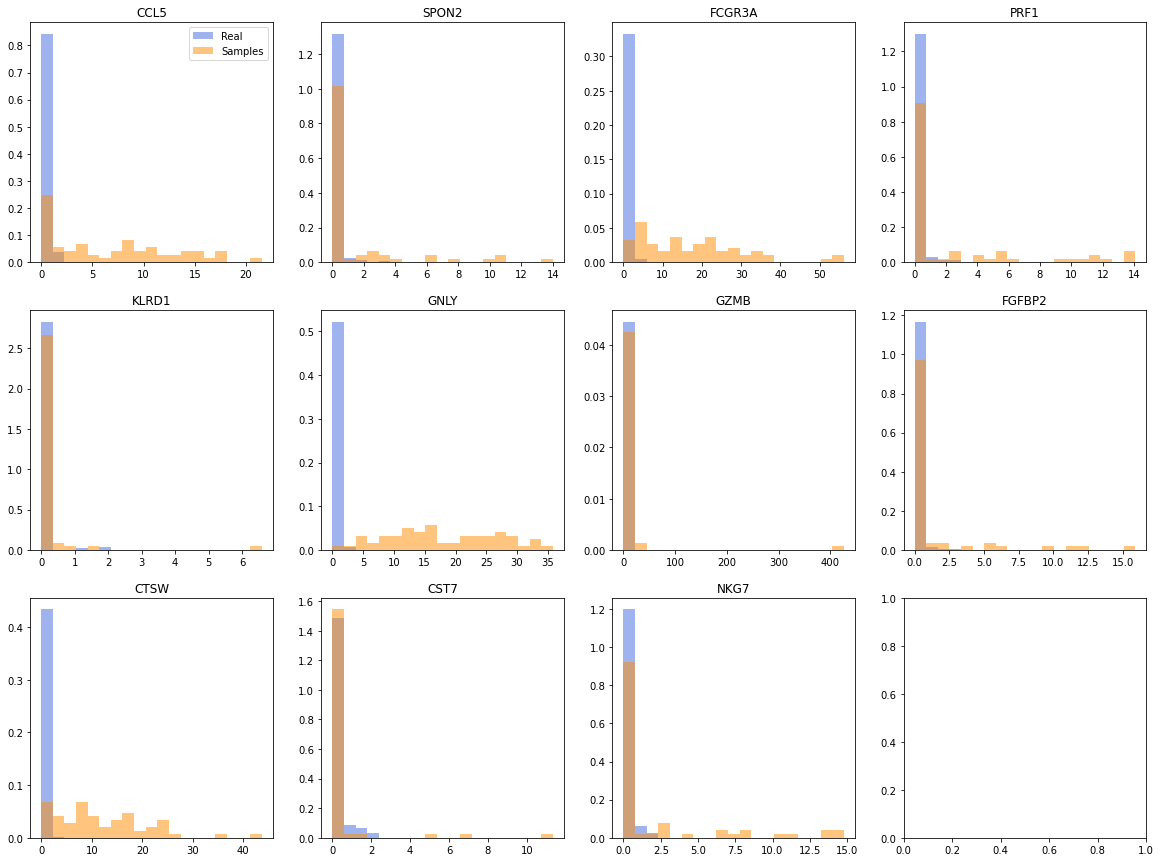

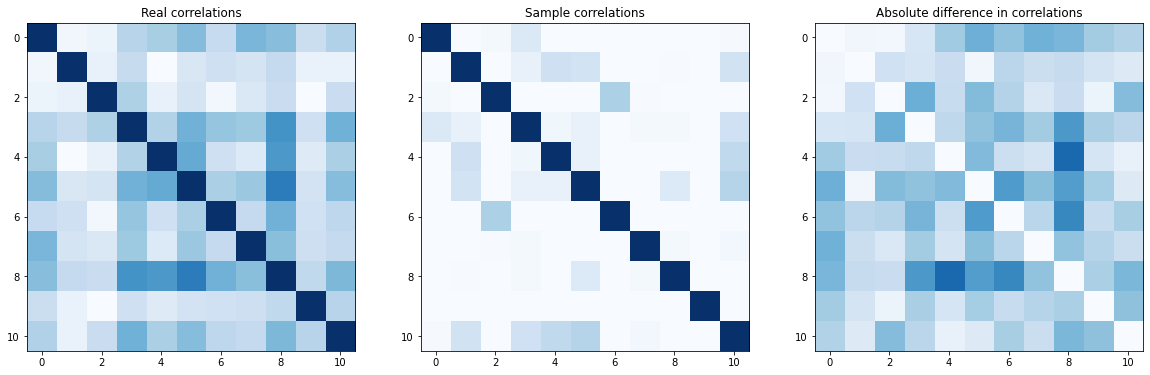

Class 1


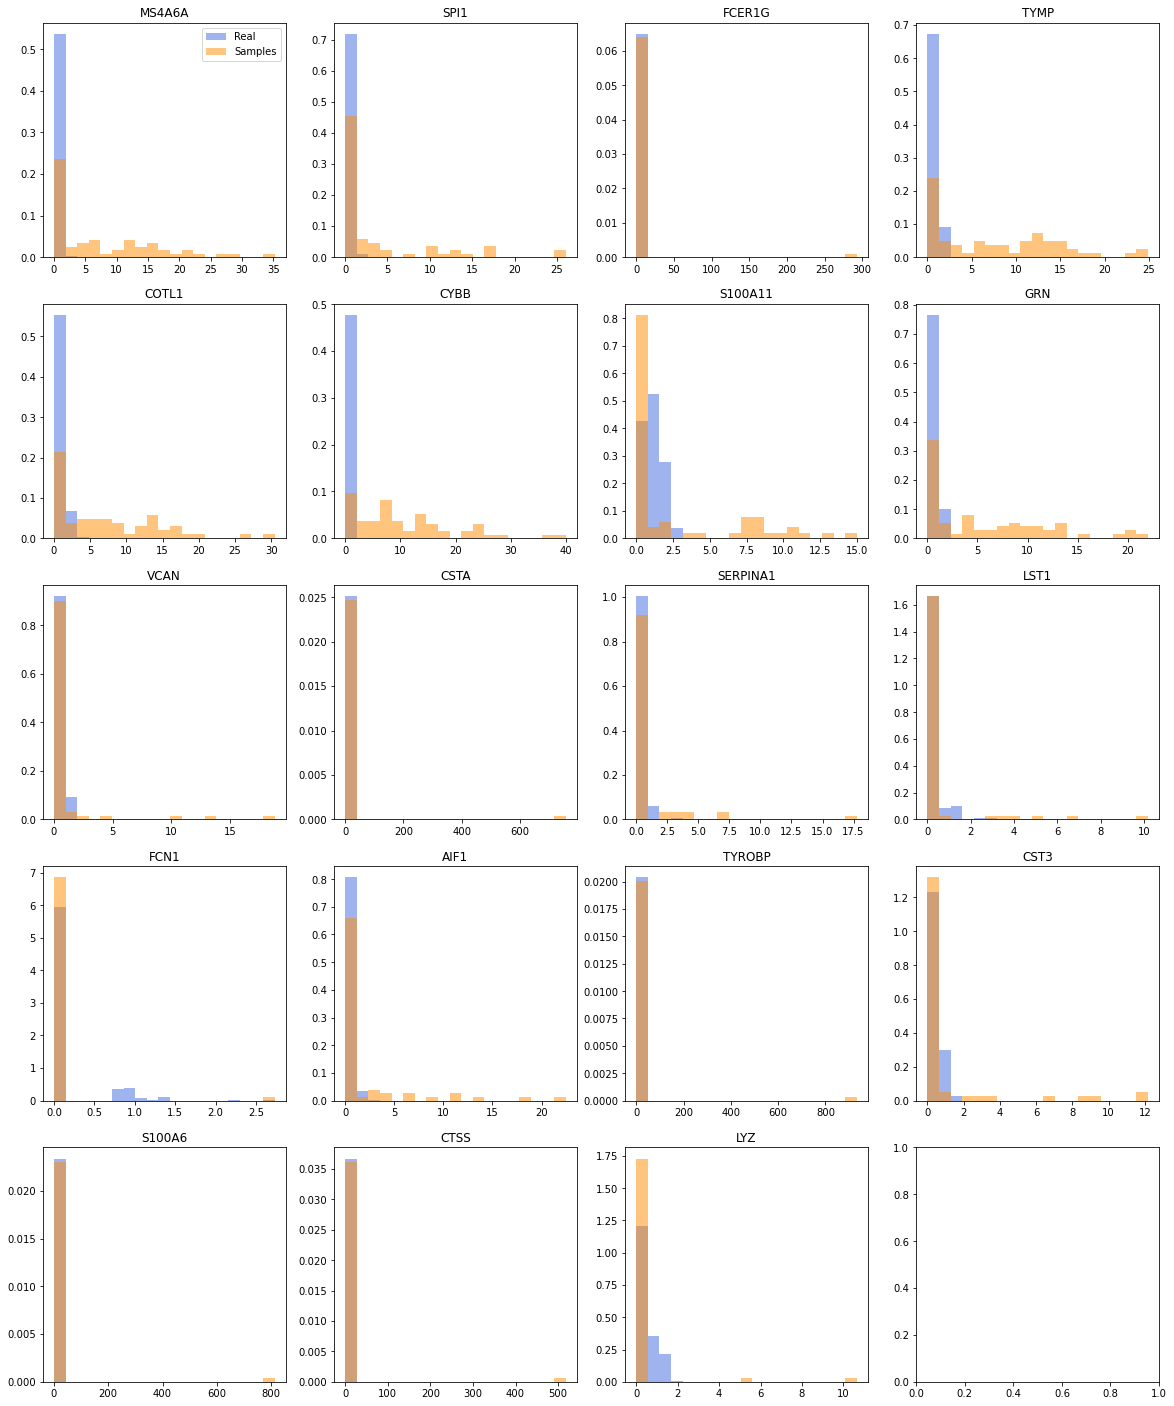

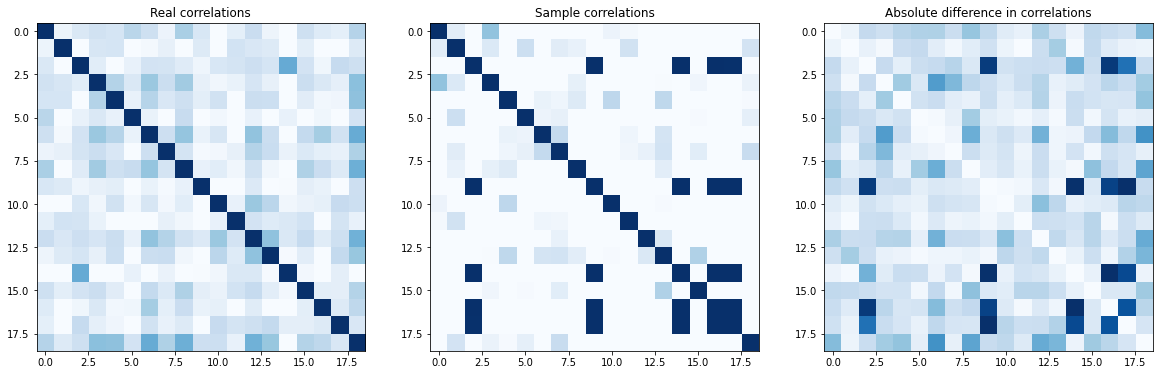

Class 2


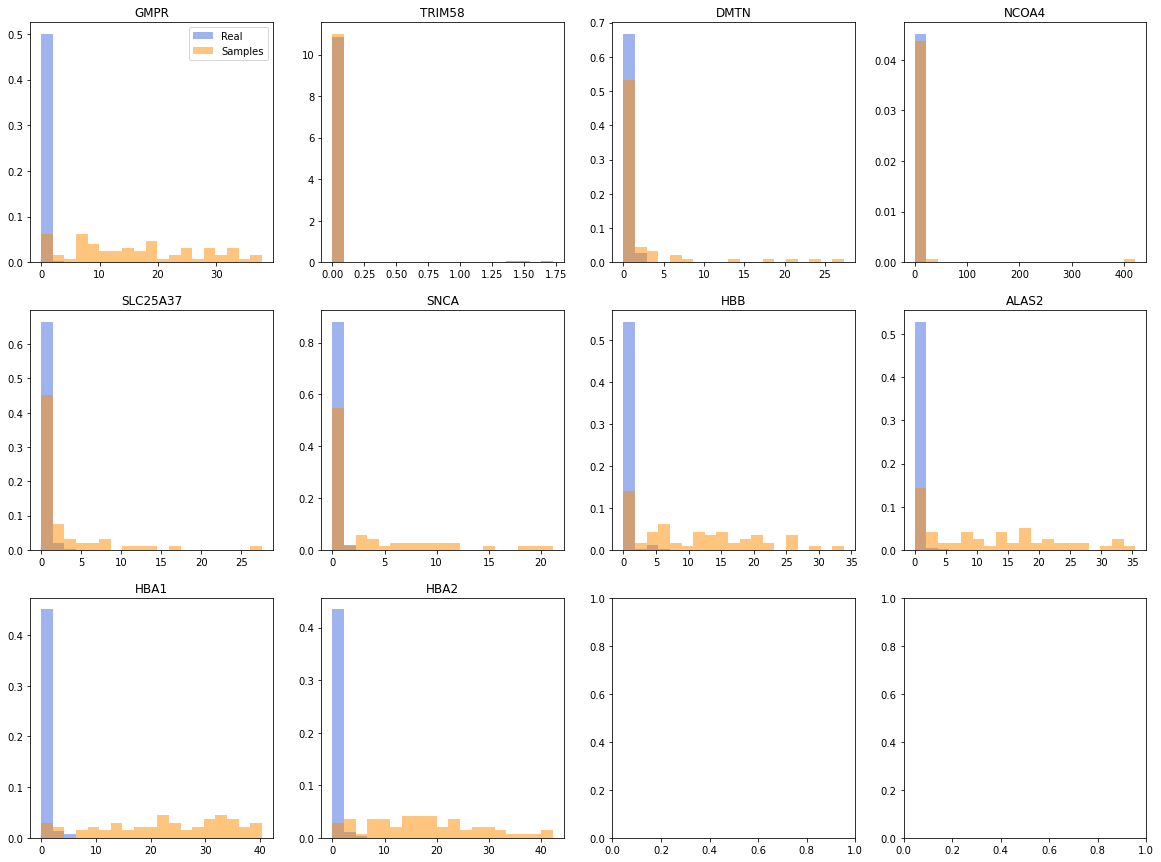

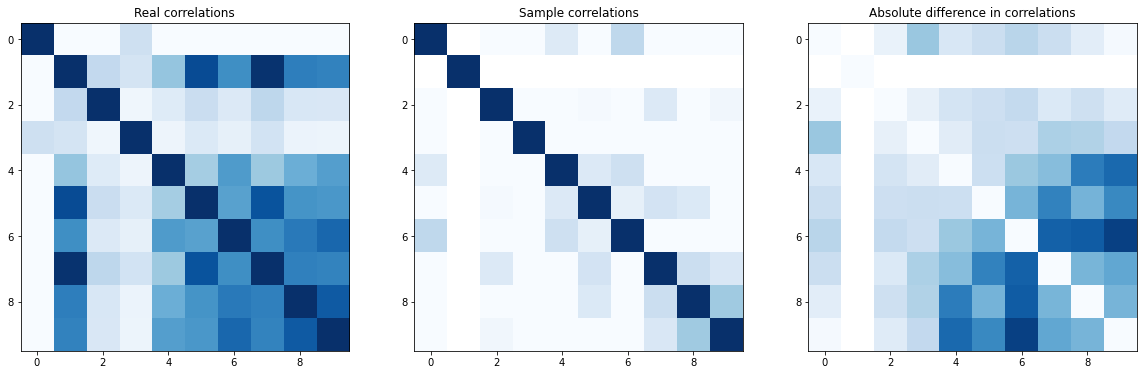

Class 3


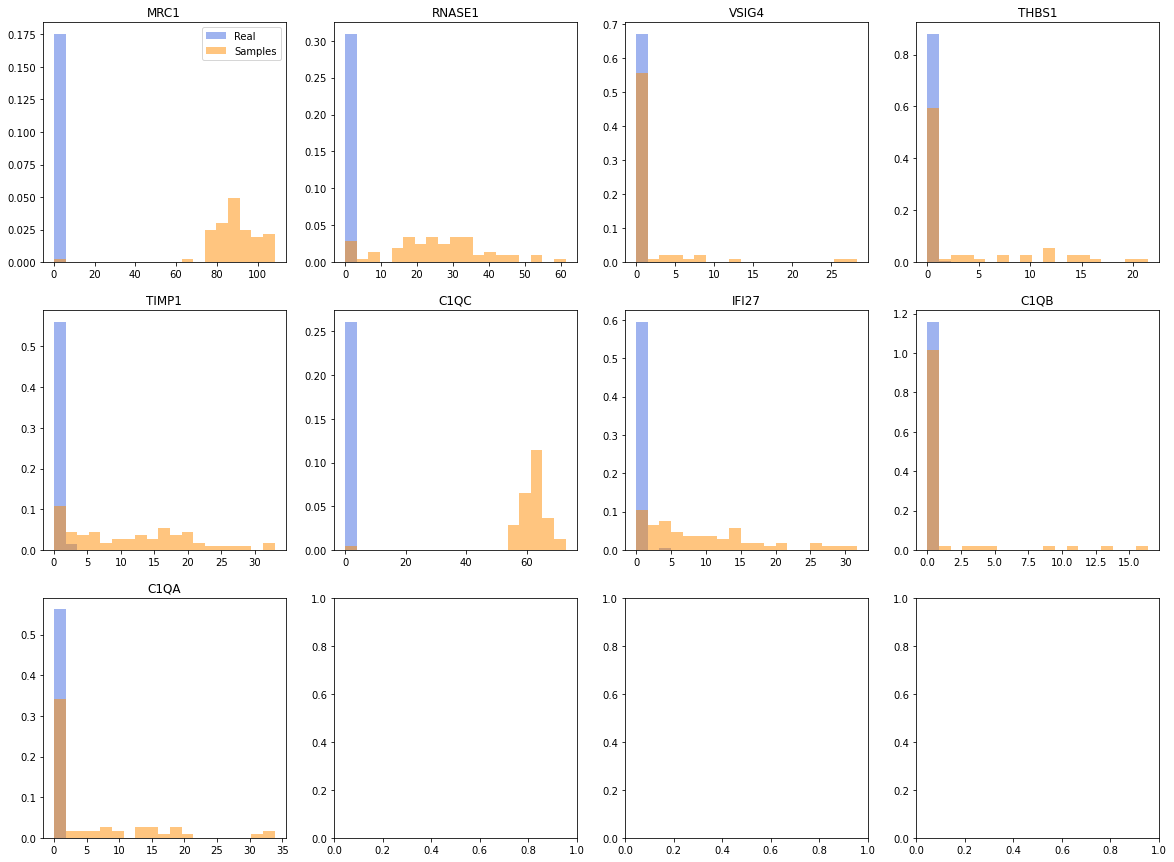

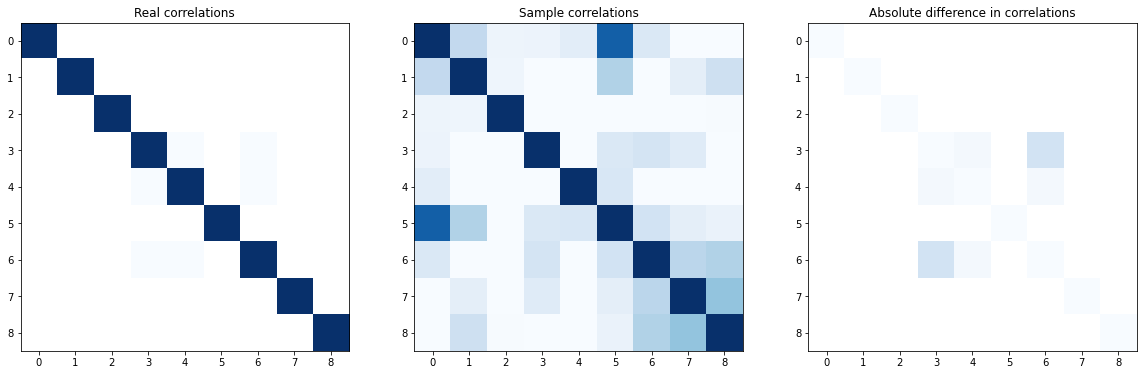

Class 4


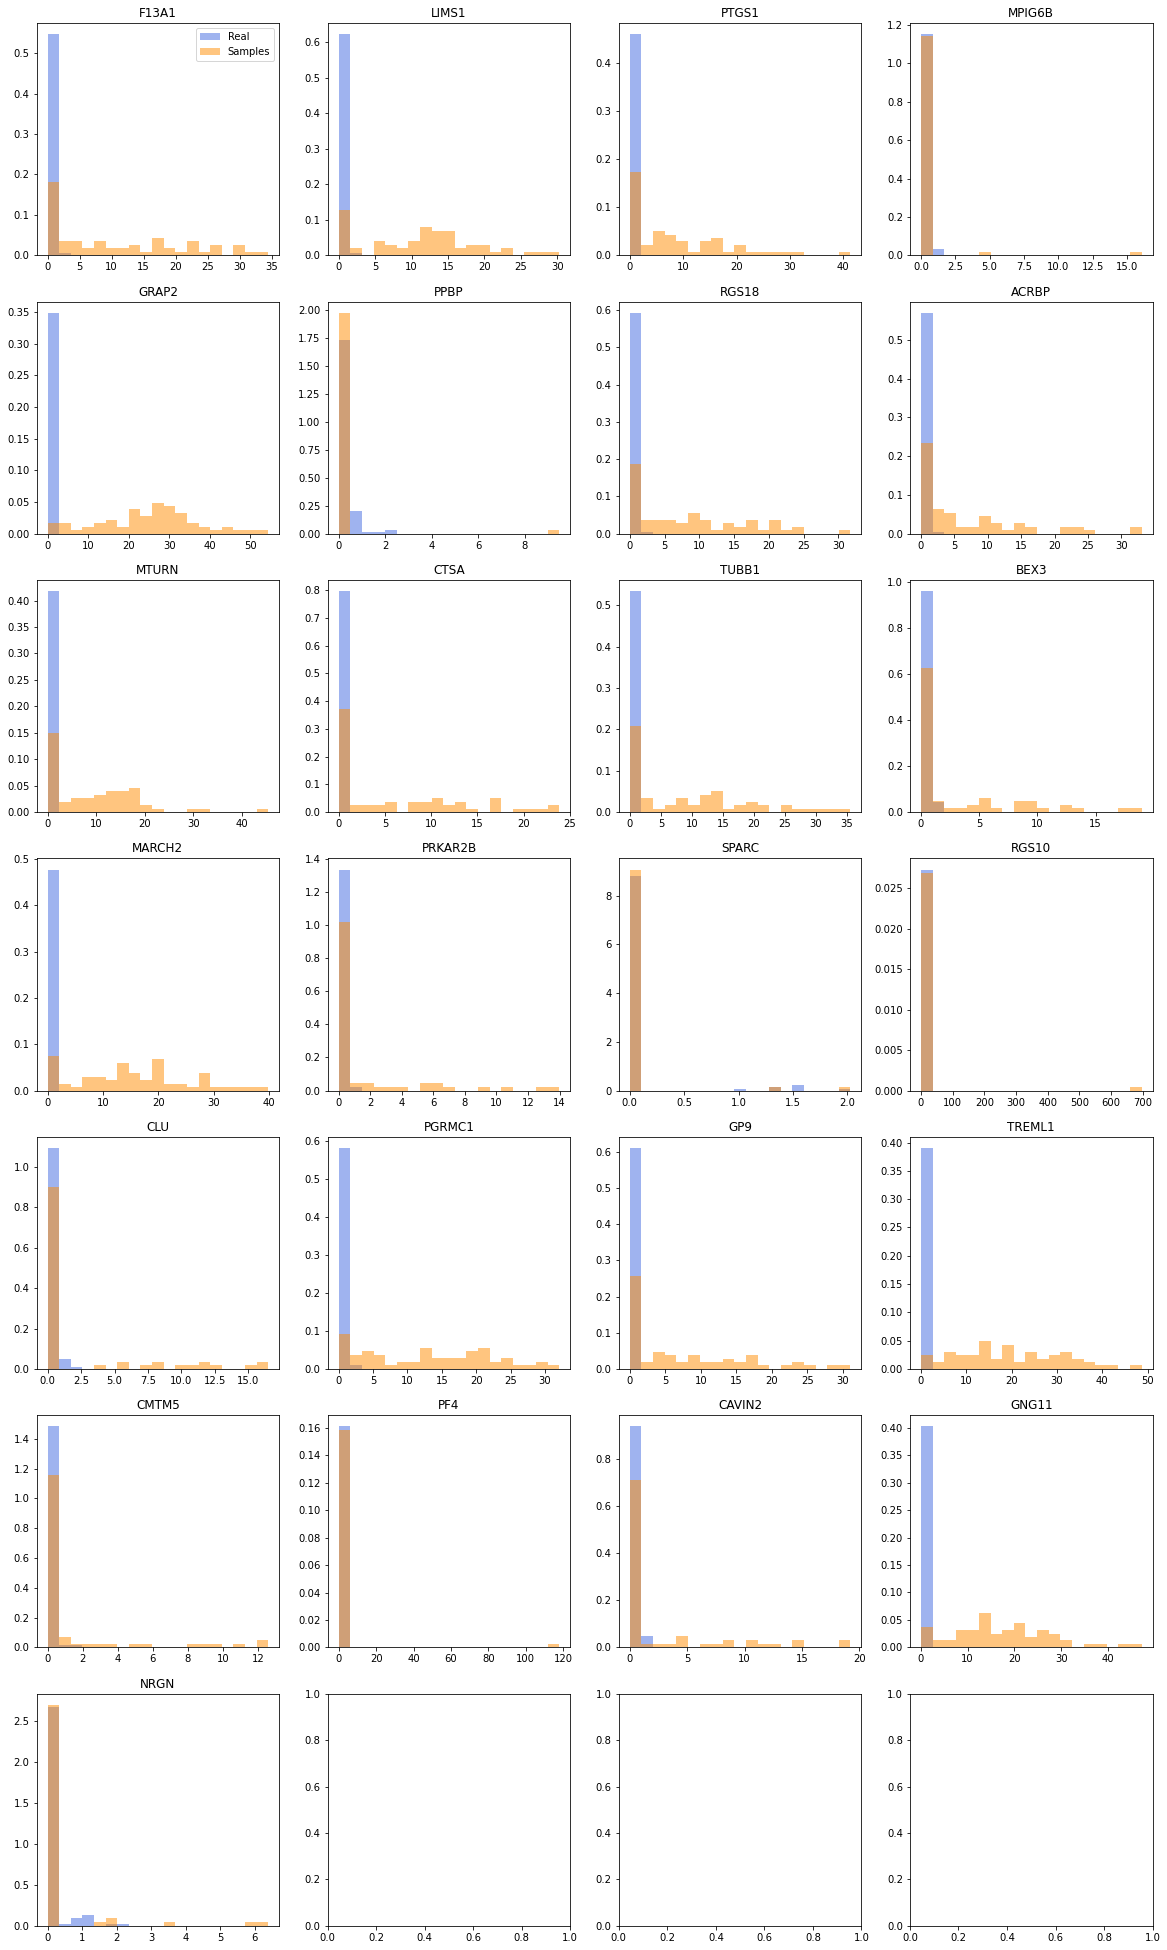

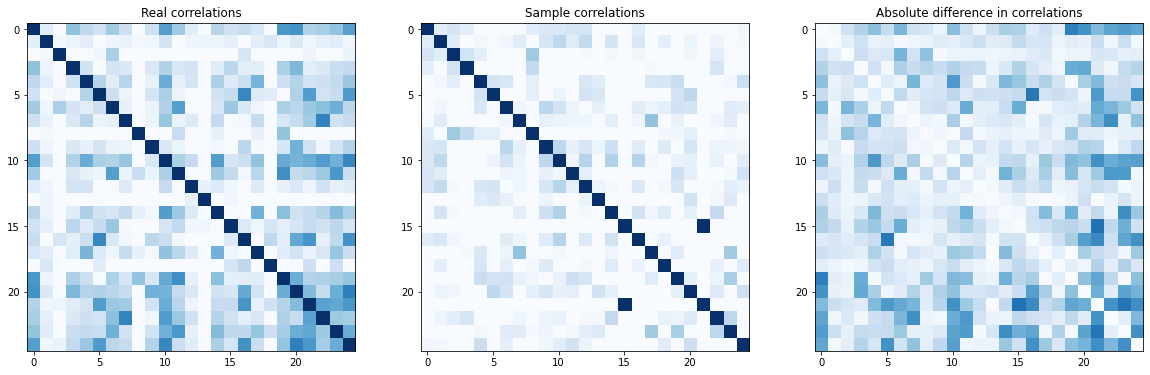

Class 5


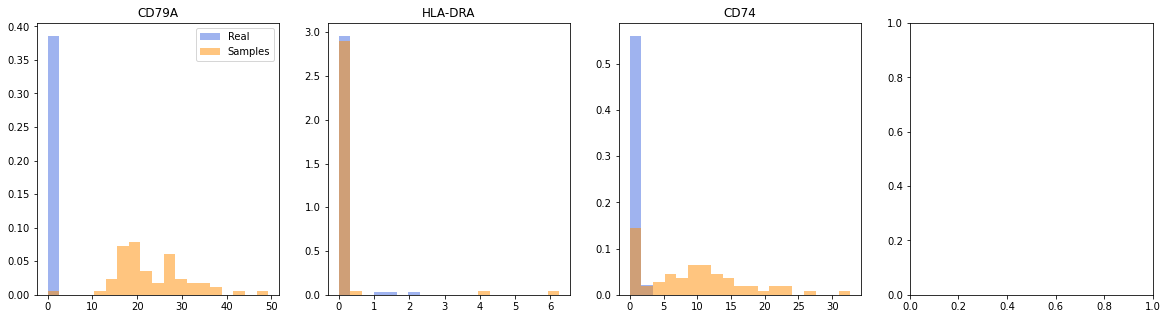

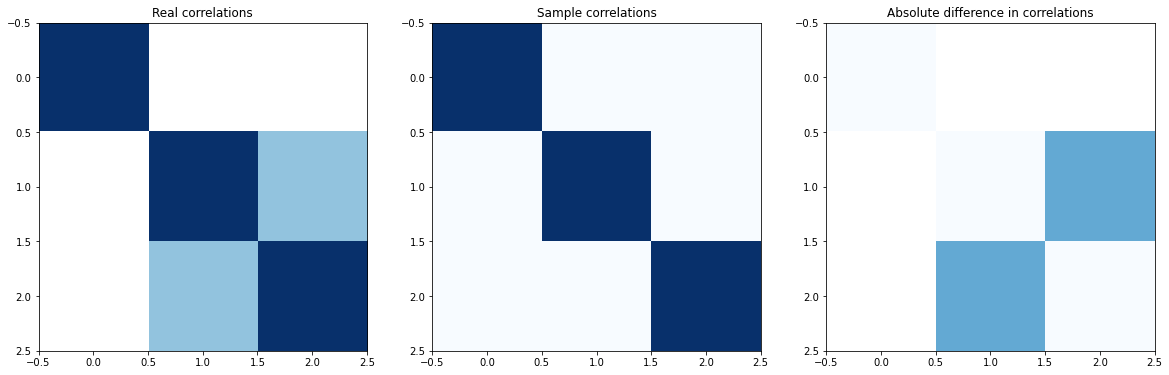

Class 7


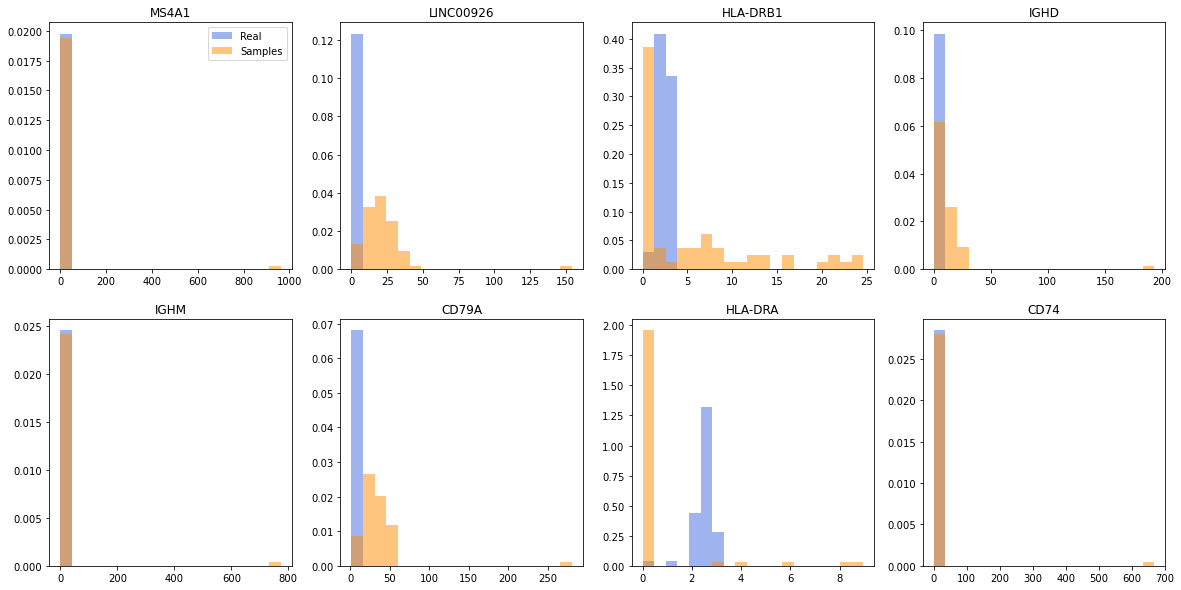

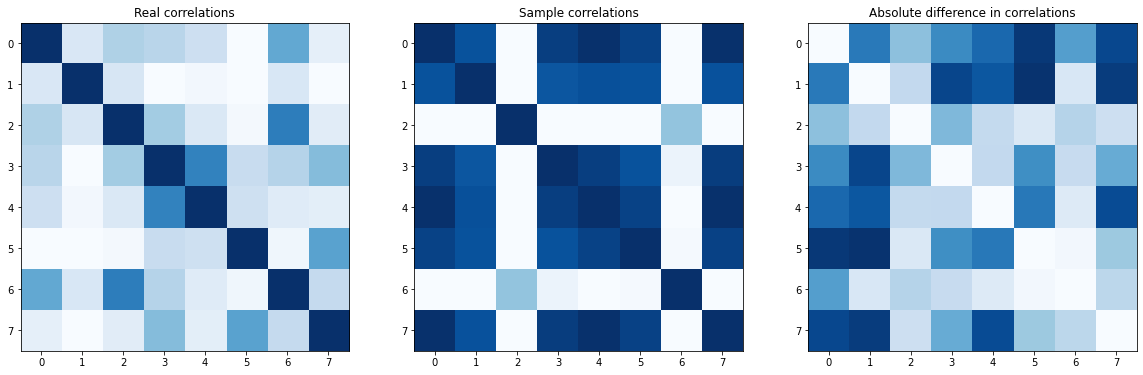

Class 10
Class 12


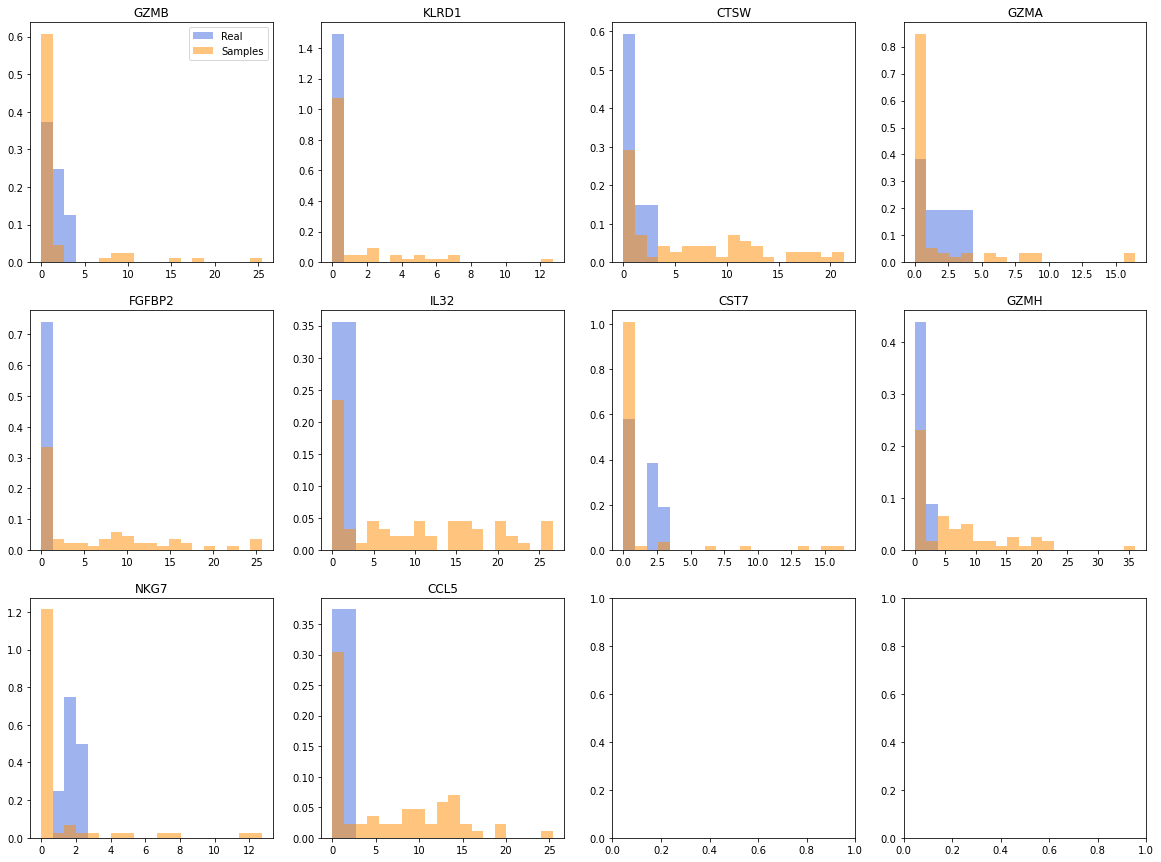

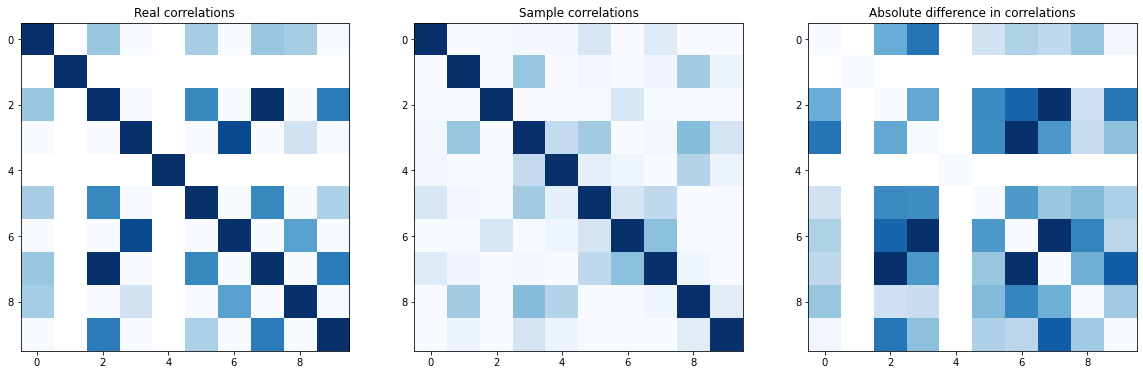

In [31]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.cpu().numpy())
    targets.append(y.cpu().numpy())
data = np.concatenate(data)
targets = np.concatenate(targets)

for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    # Decide which features to plot
    feature_inds = []
    for gene in marker_genes[class_to_sample]:
        if gene in gene_names:
            feature_inds.append(np.where(gene_names == gene)[0][0])
    num_features = len(feature_inds)
    
    if not num_features:
        continue
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    if num_rows == 1:
        ax = [ax]
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        sample_vals[sample_vals < 0] = 0  # Threshold to 0
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title(gene_names[f_i])
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

### Transmutation

In [18]:
class_1, class_2 = 1, 2
branch_time = branch_defs[min(
    range(len(branch_defs)),
    key=(lambda i: branch_defs[i][1] if (
        class_1 in branch_defs[i][0] and class_2 in branch_defs[i][0]
    ) else float("inf"))
)][1]

orig_1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.cell_cluster == class_1)[0], size=200, replace=False)
])
orig_2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.cell_cluster == class_2)[0], size=200, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
forward_2_to_1 = np.empty((len(all_t),) + orig_2.shape)
backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_2.shape)
for t_i, t in enumerate(all_t):
    forward_1_to_2[t_i] = sde.forward(
        orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_2_to_1[t_i] = sde.forward(
        orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_1_to_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
        num_steps=50
    )
    backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

    last_2_to_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
        num_steps=50
    )
    backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

orig_1, orig_2 = orig_1.cpu().numpy(), orig_2.cpu().numpy()
before_1_to_2, after_1_to_2 = forward_1_to_2[0], backward_1_to_2[-1]
before_2_to_1, after_2_to_1 = forward_2_to_1[0], backward_2_to_1[-1]
num_features = before_1_to_2.shape[1]

In [19]:
# Compute Wasserstein distance between predicted and true distributions
before_1_to_2_vs_true_dists = np.empty(num_features)
after_1_to_2_vs_true_dists = np.empty(num_features)
before_2_to_1_vs_true_dists = np.empty(num_features)
after_2_to_1_vs_true_dists = np.empty(num_features)
for i in range(num_features):
    before_1_to_2_vs_true_dists[i] = scipy.stats.wasserstein_distance(before_1_to_2[:, i], orig_1[:, i])
    after_1_to_2_vs_true_dists[i] = scipy.stats.wasserstein_distance(after_1_to_2[:, i], orig_2[:, i])
    before_2_to_1_vs_true_dists[i] = scipy.stats.wasserstein_distance(before_2_to_1[:, i], orig_2[:, i])
    after_2_to_1_vs_true_dists[i] = scipy.stats.wasserstein_distance(after_2_to_1[:, i], orig_1[:, i])

# Compute Wasserstein distance between different true distributions
true_feature_dists = np.empty(num_features)
for i in range(num_features):
    true_feature_dists[i] = scipy.stats.wasserstein_distance(orig_1[:, i], orig_2[:, i])

# Compute correlation of features before and after transmutation
corrs_1_to_2, corrs_2_to_1 = np.empty(num_features), np.empty(num_features)
for i in range(num_features):
    corrs_1_to_2[i] = scipy.stats.pearsonr(
        before_1_to_2[:, i], after_1_to_2[:, i]
    )[0]
    corrs_2_to_1[i] = scipy.stats.pearsonr(
        before_2_to_1[:, i], after_2_to_1[:, i]
    )[0]

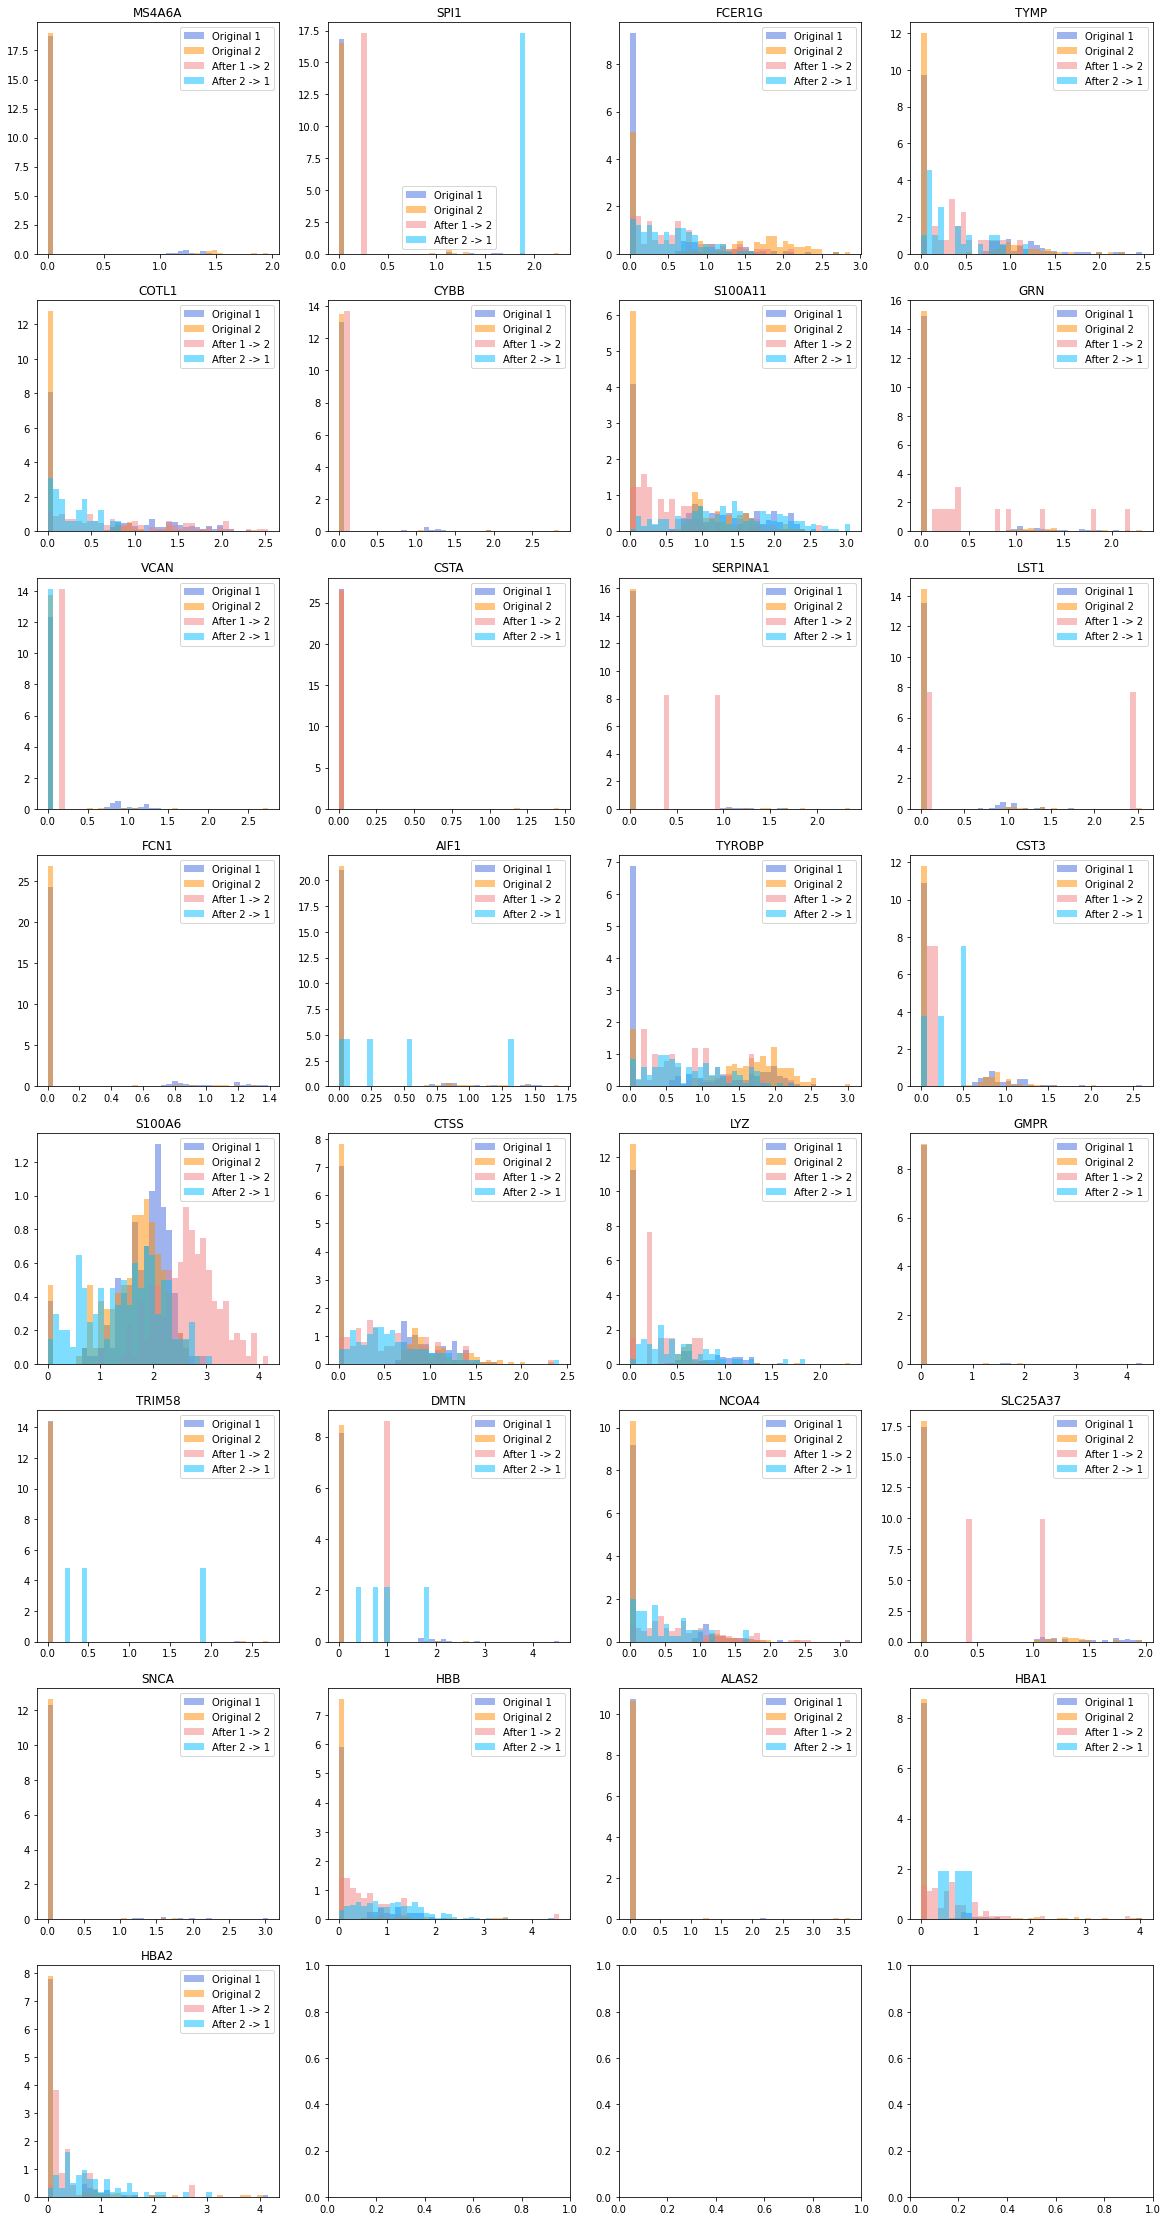

In [24]:
# Plot marker genes

feature_inds = []
for gene in np.concatenate([marker_genes[class_1], marker_genes[class_2]]):
    if gene in gene_names:
        feature_inds.append(np.where(gene_names == gene)[0][0])
num_to_plot = len(feature_inds)

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))
num_bins = 40

# Plot feature values
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    orig_1_vals, orig_2_vals = orig_1[:, f_i], orig_2[:, f_i]
    after_1_to_2_vals, after_2_to_1_vals = after_1_to_2[:, f_i], after_2_to_1[:, f_i]

    all_vals = np.concatenate([orig_1_vals, orig_2_vals, after_1_to_2_vals, after_2_to_1_vals])
    bins = np.linspace(
        max(0, np.min(all_vals)), min(np.max(all_vals), 20), num_bins
    )
    ax[r][c].hist(orig_1_vals, bins=bins, color="royalblue", label=("Original %d" % class_1), density=True, alpha=0.5)
    ax[r][c].hist(orig_2_vals, bins=bins, color="darkorange", label=("Original %d" % class_2), density=True, alpha=0.5)
    ax[r][c].hist(after_1_to_2_vals, bins=bins, color="lightcoral", label=("After %d -> %d" % (class_1, class_2)), density=True, alpha=0.5)
    ax[r][c].hist(after_2_to_1_vals, bins=bins, color="deepskyblue", label=("After %d -> %d" % (class_2, class_1)), density=True, alpha=0.5)
    ax[r][c].set_title(gene_names[f_i])
    ax[r][c].legend()
plt.show()

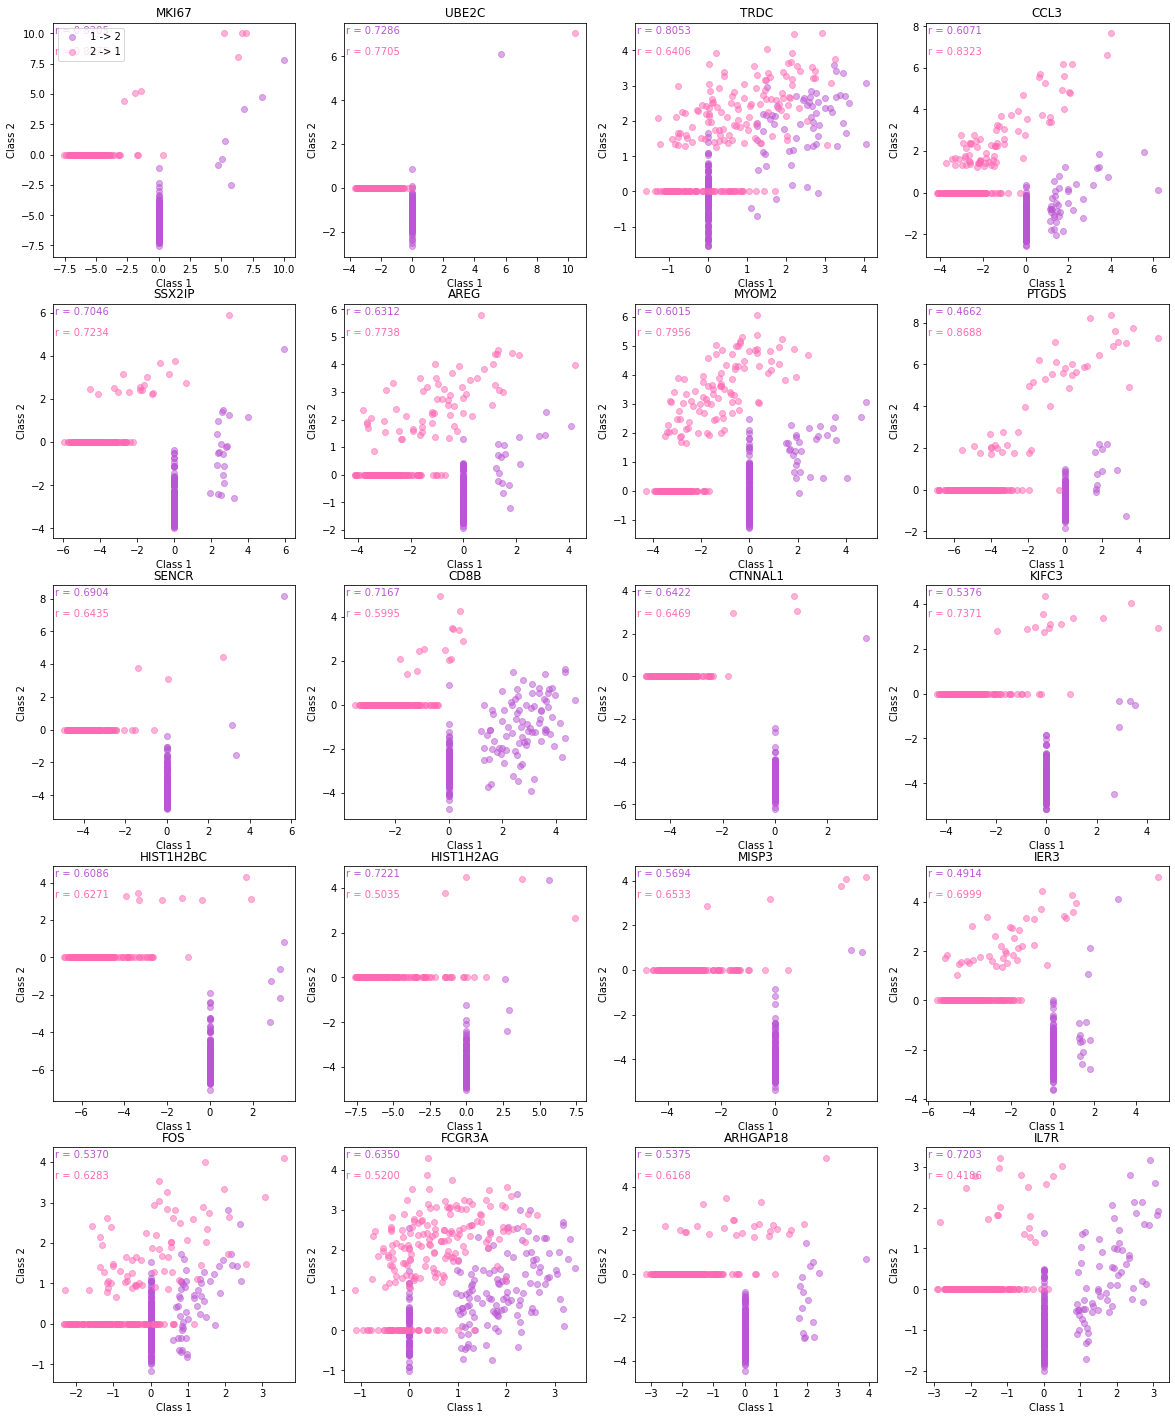

In [22]:
# Find genes where:
# 1) The correlation of before vs after transmutation is high
num_to_plot = 20

mean_corrs = np.mean(np.stack([corrs_1_to_2, corrs_2_to_1], axis=1), axis=1)
feature_inds = np.flip(np.argsort(mean_corrs))
feature_inds = feature_inds[np.isfinite(mean_corrs[feature_inds])]
feature_inds = feature_inds[:num_to_plot]

# feature_inds = [np.where(gene_names == gene)[0][0] for gene in genes_of_interest if gene in gene_names]

num_cols = 4
num_rows = int(np.ceil(num_to_plot / num_cols))

# Plot correlations
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
for i, f_i in enumerate(feature_inds):
    r, c = i // num_cols, i % num_cols
    
    before_1_to_2_vals, after_1_to_2_vals = before_1_to_2[:, f_i], after_1_to_2[:, f_i]
    before_2_to_1_vals, after_2_to_1_vals = before_2_to_1[:, f_i], after_2_to_1[:, f_i]
    
    ax[r][c].scatter(before_1_to_2_vals, after_1_to_2_vals, alpha=0.5, color="mediumorchid", label=("%d -> %d" % (class_1, class_2)))
    ax[r][c].scatter(after_2_to_1_vals, before_2_to_1_vals, alpha=0.5, color="hotpink", label=("%d -> %d" % (class_2, class_1)))
    
    corr_1_to_2 = scipy.stats.pearsonr(before_1_to_2_vals, after_1_to_2_vals)[0]
    corr_2_to_1 = scipy.stats.pearsonr(before_2_to_1_vals, after_2_to_1_vals)[0]
    
    ax[r][c].text(
        0.01, 0.99, "r = %.4f" % corr_1_to_2,
        ha="left", va="top", transform=ax[r][c].transAxes, color="mediumorchid"
    )
    ax[r][c].text(
        0.01, 0.90, "r = %.4f" % corr_2_to_1,
        ha="left", va="top", transform=ax[r][c].transAxes, color="hotpink"
    )
    
    ax[r][c].set_xlabel("Class %d" % class_1)
    ax[r][c].set_ylabel("Class %d" % class_2)
    ax[r][c].set_title(gene_names[f_i])
ax[0][0].legend()
plt.show()